In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytz


RESULTS_FOLDER = 'smile_osa_cnn'

Found 18 patient result files. Processing...


/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_75829/3150653192.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(



Plot successfully saved to 'patient_event_totals_by_id.png'


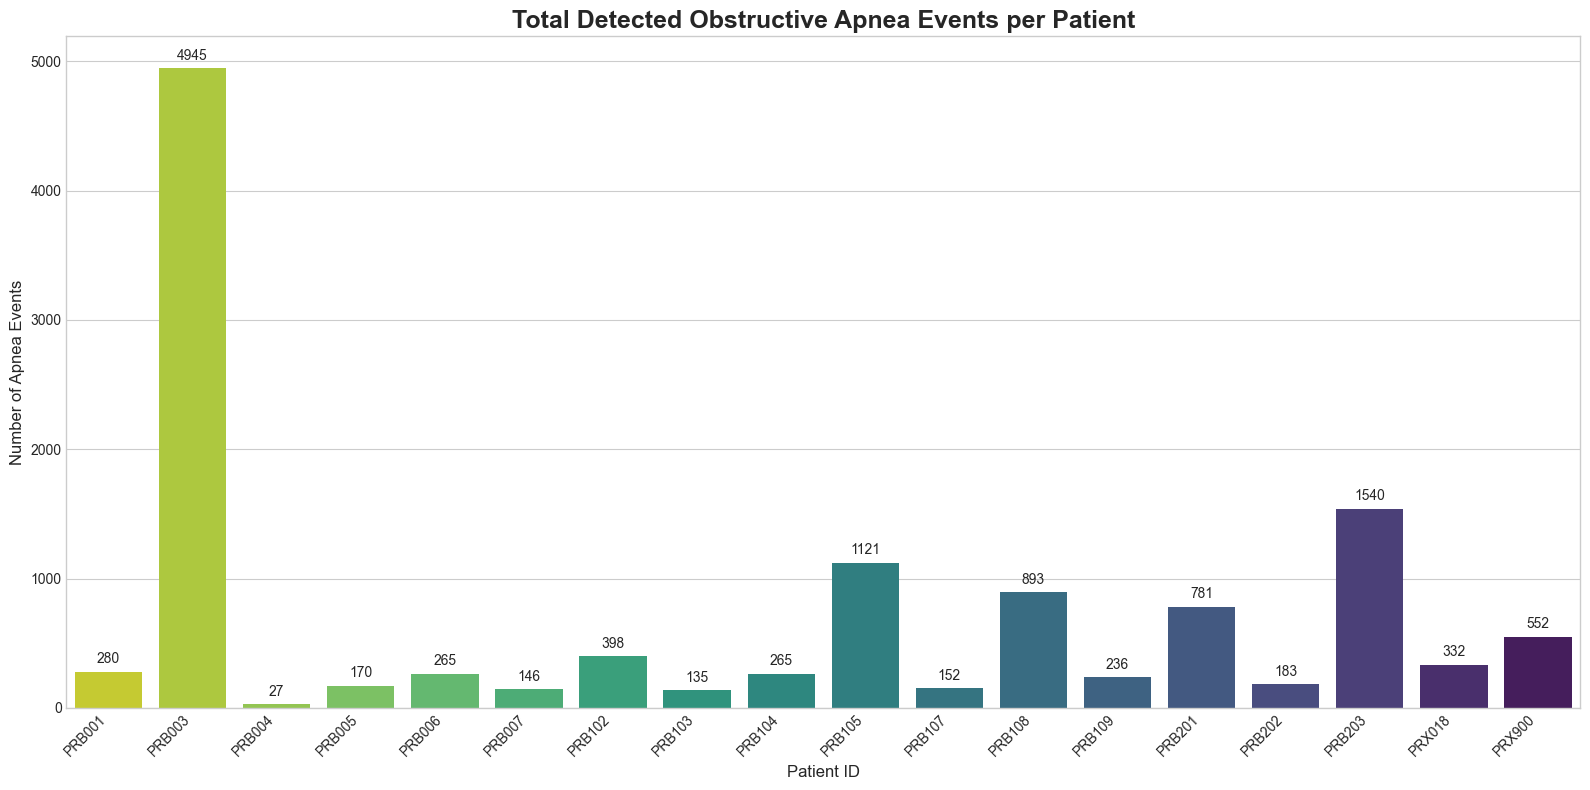

In [2]:

def plot_total_events_per_patient(results_folder, output_filename="patient_event_totals_by_id.png"):
    """
    Finds all patient OSA result CSVs in a folder, counts the events for each,
    and generates a bar plot summarizing the totals, ordered by Patient ID.

    Args:
        results_folder (str): The path to the folder containing the _osa.csv files.
        output_filename (str): The filename for the saved plot image.
    """
    # --- 1. Find and process all result files ---
    search_pattern = os.path.join(results_folder, "*_osa.csv")
    result_files = glob.glob(search_pattern)

    if not result_files:
        print(f"Error: No '*_osa.csv' files found in the folder: '{results_folder}'")
        return

    print(f"Found {len(result_files)} patient result files. Processing...")

    patient_events = {}
    for file_path in result_files:
        filename = os.path.basename(file_path)
        patient_id = filename.split('_osa.csv')[0]

        try:
            df = pd.read_csv(file_path)
            event_count = len(df)
            patient_events[patient_id] = event_count
        except pd.errors.EmptyDataError:
            patient_events[patient_id] = 0
        except Exception as e:
            print(f"Could not process file {file_path}: {e}")

    # --- 2. Prepare data for plotting ---
    if not patient_events:
        print("No valid patient data to plot.")
        return

    events_df = pd.DataFrame(list(patient_events.items()), columns=['PatientID', 'EventCount'])

    # <<< FIX: Sort the DataFrame by PatientID instead of EventCount
    events_df_sorted = events_df.sort_values('PatientID', ascending=True)

    # --- 3. Create and customize the plot ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(16, 8))

    ax = sns.barplot(
        x='PatientID',
        y='EventCount',
        data=events_df_sorted,
        palette='viridis_r' # Reversed palette for variety
    )

    for p in ax.patches:
        ax.annotate(
            format(p.get_height(), '.0f'),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha = 'center',
            va = 'center',
            xytext = (0, 9),
            textcoords = 'offset points'
        )

    plt.title('Total Detected Obstructive Apnea Events per Patient', fontsize=18, fontweight='bold')
    plt.xlabel('Patient ID', fontsize=12)
    plt.ylabel('Number of Apnea Events', fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    # --- 4. Save and show the plot ---
    # I've updated the output filename to reflect the new sorting
    plt.savefig(output_filename, dpi=300)
    print(f"\nPlot successfully saved to '{output_filename}'")
    
    plt.show()



plot_total_events_per_patient(results_folder=RESULTS_FOLDER)

Found 18 patient result files. Aggregating data...
Total events from all patients: 12421

Plot successfully saved to 'nightly_total_distribution.png'


/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_75829/143431102.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


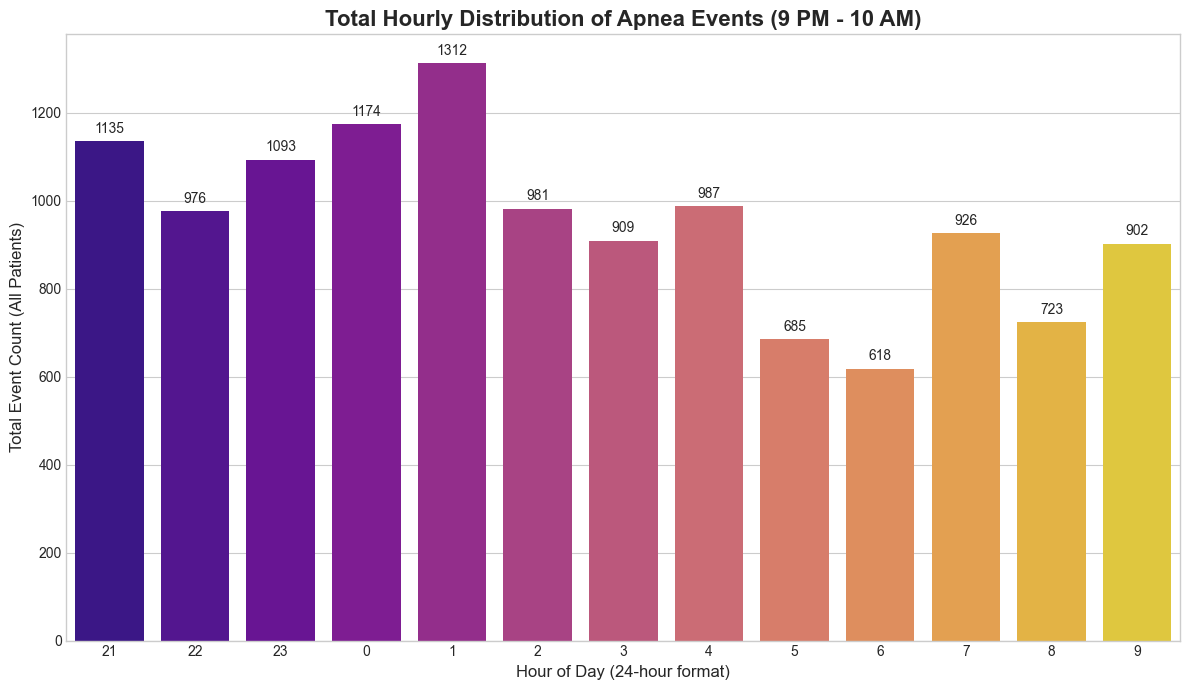

In [3]:
# plot_total_hourly_distribution.py

import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_total_hourly_distribution(results_folder, output_filename="nightly_total_distribution.png"):
    """
    Aggregates all patient OSA events and plots their total hourly distribution
    as a simple bar chart.

    Args:
        results_folder (str): The path to the folder containing the _osa.csv files.
        output_filename (str): The filename for the saved plot image.
    """
    # --- 1. Find and aggregate all result files into a single DataFrame ---
    search_pattern = os.path.join(results_folder, "*_osa.csv")
    result_files = glob.glob(search_pattern)

    if not result_files:
        print(f"Error: No '*_osa.csv' files found in the folder: '{results_folder}'")
        return

    print(f"Found {len(result_files)} patient result files. Aggregating data...")

    all_events_df_list = []
    for file_path in result_files:
        try:
            df = pd.read_csv(file_path)
            if not df.empty:
                all_events_df_list.append(df)
        except pd.errors.EmptyDataError:
            continue
        except Exception as e:
            print(f"Could not process file {file_path}: {e}")

    if not all_events_df_list:
        print("No events found across all patient files. Nothing to plot.")
        return

    combined_df = pd.concat(all_events_df_list, ignore_index=True)
    print(f"Total events from all patients: {len(combined_df)}")

    # --- 2. Prepare data for plotting total counts ---
    # Extract the hour from the timestamp
    combined_df['hour'] = pd.to_datetime(combined_df['time'], format='%H:%M:%S').dt.hour

    # <<< MODIFIED: Group only by 'hour' to get the total count across all patients
    hourly_counts = combined_df['hour'].value_counts()

    # --- 3. Order the hours correctly for the nightly window ---
    nightly_hours_order = [21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    # Re-index the counts to match our desired order and fill in 0 for any hours with no events
    hourly_counts_sorted = hourly_counts.reindex(nightly_hours_order, fill_value=0).reset_index()
    hourly_counts_sorted.columns = ['Hour', 'EventCount']

    # --- 4. Create and customize the plot ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))

    ax = sns.barplot(
        x='Hour',
        y='EventCount',
        data=hourly_counts_sorted,
        palette='plasma' # Use a different color palette
    )

    # Add the exact count on top of each bar
    for p in ax.patches:
        ax.annotate(
            format(p.get_height(), '.0f'),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 9),
            textcoords='offset points'
        )

    plt.title('Total Hourly Distribution of Apnea Events (9 PM - 10 AM)', fontsize=16, fontweight='bold')
    plt.xlabel('Hour of Day (24-hour format)', fontsize=12)
    plt.ylabel('Total Event Count (All Patients)', fontsize=12)
    plt.xticks(ticks=range(len(nightly_hours_order)), labels=nightly_hours_order)
    plt.tight_layout()

    # --- 5. Save and show the plot ---
    plt.savefig(output_filename, dpi=300)
    print(f"\nPlot successfully saved to '{output_filename}'")
    
    plt.show()

if __name__ == "__main__":
    RESULTS_FOLDER = './smile_osa_cnn'
    plot_total_hourly_distribution(results_folder=RESULTS_FOLDER)

Found 18 patient result files. Aggregating event data...
Aggregating raw data to calculate total samples per hour...


/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_75829/2796343586.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(



Plot successfully saved to 'nightly_normalized_total_distribution.png'


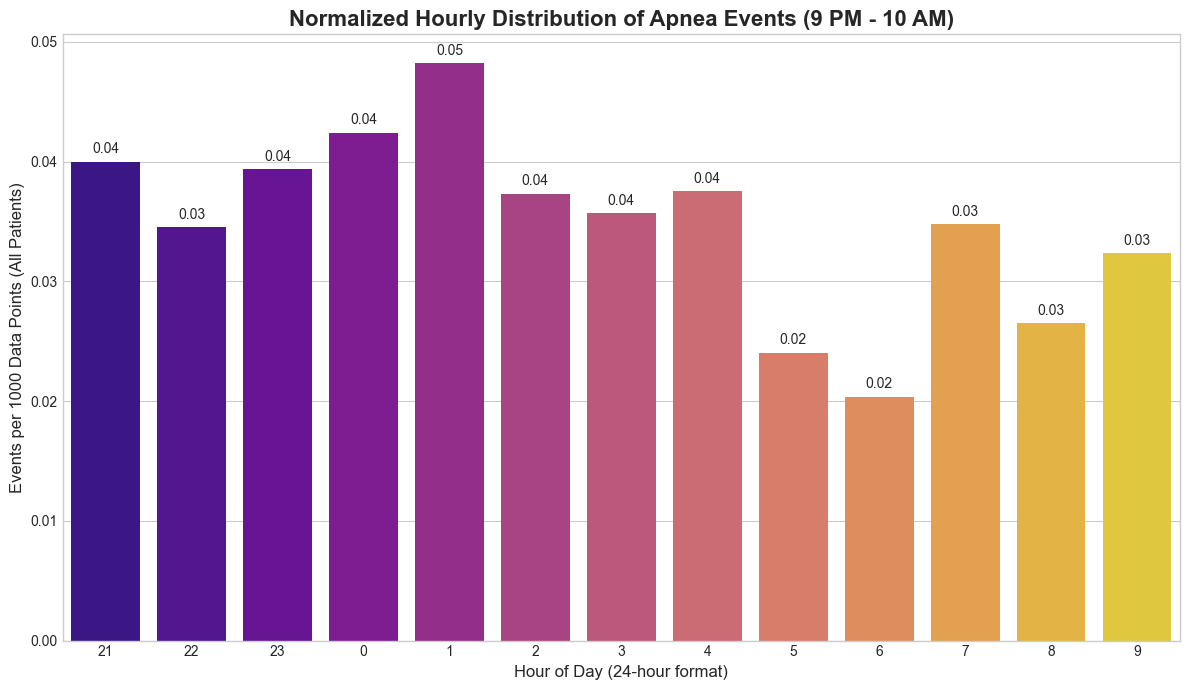

In [4]:
# plot_normalized_total_hourly.py

import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytz

def plot_normalized_total_hourly_distribution(results_folder, data_root_folder, output_filename="nightly_normalized_total_distribution.png"):
    """
    Aggregates all patient events and raw data to plot the event rate per 1000 data points
    for each hour of the night.
    """
    # --- 1. Find and aggregate all EVENT files ---
    event_files = glob.glob(os.path.join(results_folder, "*_osa.csv"))
    if not event_files:
        print(f"Error: No '*_osa.csv' files found in '{results_folder}'")
        return

    print(f"Found {len(event_files)} patient result files. Aggregating event data...")
    all_events_df_list = [pd.read_csv(f) for f in event_files if not pd.read_csv(f).empty]
    if not all_events_df_list:
        print("No events found. Aborting.")
        return
    event_df = pd.concat(all_events_df_list, ignore_index=True)
    event_df['hour'] = pd.to_datetime(event_df['time'], format='%H:%M:%S').dt.hour
    hourly_event_counts = event_df['hour'].value_counts()

    # --- 2. Find and aggregate all RAW DATA files ---
    print("Aggregating raw data to calculate total samples per hour...")
    raw_files = glob.glob(os.path.join(data_root_folder, "*/Respeck/*.csv"))
    if not raw_files:
        print(f"Error: No raw data files found in '{data_root_folder}'. Cannot normalize.")
        return

    try:
        raw_df_list = [pd.read_csv(file, on_bad_lines='skip', usecols=['interpolatedPhoneTimestamp']) for file in raw_files]
        raw_df_list = [df for df in raw_df_list if not df.empty]
        if not raw_df_list:
            print("All raw data files were empty or unreadable.")
            return
        raw_df = pd.concat(raw_df_list, ignore_index=True)
    except Exception as e:
        print(f"A critical error occurred while reading raw files: {e}")
        return

    # --- 3. Calculate total data points per hour from raw data ---
    scotland_tz = pytz.timezone('Europe/London')
    raw_df['datetime'] = pd.to_datetime(raw_df['interpolatedPhoneTimestamp'], unit='ms', errors='coerce', utc=True).dt.tz_convert(scotland_tz)
    raw_df.dropna(subset=['datetime'], inplace=True)
    raw_df['hour'] = raw_df['datetime'].dt.hour
    hourly_sample_counts = raw_df['hour'].value_counts()

    # --- 4. Prepare data for plotting by normalizing ---
    nightly_hours_order = [21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    normalized_rates = []

    for hour in nightly_hours_order:
        event_count = hourly_event_counts.get(hour, 0)
        sample_count = hourly_sample_counts.get(hour, 0)
        
        if sample_count > 0:
            # Calculate events per 1000 data points
            rate = (event_count / sample_count) * 1000
        else:
            rate = 0
        normalized_rates.append({'Hour': hour, 'NormalizedRate': rate})

    normalized_df = pd.DataFrame(normalized_rates)

    # --- 5. Create and customize the plot ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))

    ax = sns.barplot(
        x='Hour',
        y='NormalizedRate',
        data=normalized_df,
        palette='plasma'
    )

    for p in ax.patches:
        ax.annotate(
            format(p.get_height(), '.2f'), # Format to two decimal places
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 9),
            textcoords='offset points'
        )

    plt.title('Normalized Hourly Distribution of Apnea Events (9 PM - 10 AM)', fontsize=16, fontweight='bold')
    plt.xlabel('Hour of Day (24-hour format)', fontsize=12)
    plt.ylabel('Events per 1000 Data Points (All Patients)', fontsize=12)
    plt.xticks(ticks=range(len(nightly_hours_order)), labels=nightly_hours_order)
    plt.tight_layout()

    # --- 6. Save and show the plot ---
    plt.savefig(output_filename, dpi=300)
    print(f"\nPlot successfully saved to '{output_filename}'")
    
    plt.show()

if __name__ == "__main__":
    RESULTS_FOLDER = './smile_osa_cnn'
    DATA_ROOT_FOLDER = '../data/Smile'
    plot_normalized_total_hourly_distribution(
        results_folder=RESULTS_FOLDER, 
        data_root_folder=DATA_ROOT_FOLDER
    )

--- Processing single patient: PRB003 ---
Found 1165 total events for patient PRB003.
Found 49 raw data files. Aggregating...
Found 45270192 total raw data points for this patient.

Plot successfully saved to 'PRB003_normalized_hourly_distribution.png'


/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_75829/1465819874.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


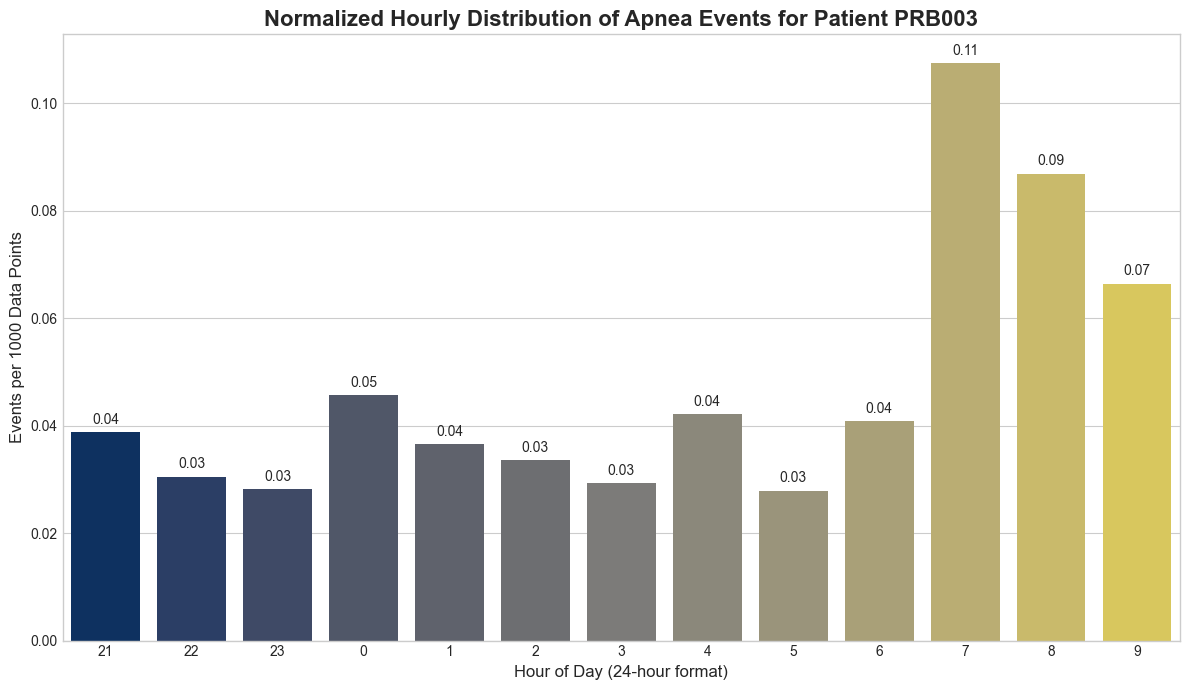

In [5]:
# plot_normalized_hourly_single_patient.py

import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytz

def plot_normalized_hourly_for_patient(patient_id_prefix, results_folder, data_root_folder, output_filename="single_patient_normalized_hourly.png"):
    """
    For a single patient, calculates the event rate per 1000 data points for each
    hour of the night and visualizes it as a bar chart.
    """
    print(f"--- Processing single patient: {patient_id_prefix} ---")

    # --- 1. Load the event file for the specified patient ---
    event_file_path = os.path.join(results_folder, f"{patient_id_prefix}_osa.csv")
    if not os.path.exists(event_file_path):
        print(f"Error: Event file not found at '{event_file_path}'")
        return

    try:
        event_df = pd.read_csv(event_file_path)
        event_df['hour'] = pd.to_datetime(event_df['time'], format='%H:%M:%S').dt.hour
        hourly_event_counts = event_df['hour'].value_counts()
        print(f"Found {len(event_df)} total events for patient {patient_id_prefix}.")
    except Exception as e:
        print(f"Could not read or process event file: {e}")
        return

    # --- 2. Find and aggregate all RAW DATA files for this patient ---
    raw_search_pattern = os.path.join(data_root_folder, f"{patient_id_prefix}*/Respeck/*.csv")
    raw_files = glob.glob(raw_search_pattern)
    if not raw_files:
        print(f"Error: No raw data files found for patient '{patient_id_prefix}' in '{data_root_folder}'. Cannot normalize.")
        return

    print(f"Found {len(raw_files)} raw data files. Aggregating...")
    try:
        raw_df_list = [pd.read_csv(file, on_bad_lines='skip', usecols=['interpolatedPhoneTimestamp']) for file in raw_files]
        raw_df_list = [df for df in raw_df_list if not df.empty]
        if not raw_df_list:
            print("All raw data files were empty or unreadable.")
            return
        raw_df = pd.concat(raw_df_list, ignore_index=True)
    except Exception as e:
        print(f"A critical error occurred while reading raw files: {e}")
        return

    # --- 3. Calculate total data points per hour from this patient's raw data ---
    scotland_tz = pytz.timezone('Europe/London')
    raw_df['datetime'] = pd.to_datetime(raw_df['interpolatedPhoneTimestamp'], unit='ms', errors='coerce', utc=True).dt.tz_convert(scotland_tz)
    raw_df.dropna(subset=['datetime'], inplace=True)
    raw_df['hour'] = raw_df['datetime'].dt.hour
    hourly_sample_counts = raw_df['hour'].value_counts()
    print(f"Found {len(raw_df)} total raw data points for this patient.")

    # --- 4. Prepare data for plotting by normalizing ---
    nightly_hours_order = [21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    normalized_rates = []

    for hour in nightly_hours_order:
        event_count = hourly_event_counts.get(hour, 0)
        sample_count = hourly_sample_counts.get(hour, 0)
        
        if sample_count > 0:
            rate = (event_count / sample_count) * 1000
        else:
            rate = 0
        normalized_rates.append({'Hour': hour, 'NormalizedRate': rate})

    normalized_df = pd.DataFrame(normalized_rates)

    # --- 5. Create and customize the plot ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))

    ax = sns.barplot(
        x='Hour',
        y='NormalizedRate',
        data=normalized_df,
        palette='cividis' # A different color palette
    )

    for p in ax.patches:
        ax.annotate(
            format(p.get_height(), '.2f'),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', xytext=(0, 9), textcoords='offset points'
        )

    plt.title(f'Normalized Hourly Distribution of Apnea Events for Patient {patient_id_prefix}', fontsize=16, fontweight='bold')
    plt.xlabel('Hour of Day (24-hour format)', fontsize=12)
    plt.ylabel('Events per 1000 Data Points', fontsize=12)
    plt.xticks(ticks=range(len(nightly_hours_order)), labels=nightly_hours_order)
    plt.tight_layout()

    # --- 6. Save and show the plot ---
    plt.savefig(output_filename, dpi=300)
    print(f"\nPlot successfully saved to '{output_filename}'")
    
    plt.show()

if __name__ == "__main__":
    # <<< MODIFIED: Specify the single patient and folders
    PATIENT_ID = "PRB003"
    RESULTS_FOLDER = './smile_osa_results'
    DATA_ROOT_FOLDER = '../data/Smile'
    
    # Create a unique filename for this patient's plot
    output_file = f"{PATIENT_ID}_normalized_hourly_distribution.png"
    
    plot_normalized_hourly_for_patient(
        patient_id_prefix=PATIENT_ID,
        results_folder=RESULTS_FOLDER, 
        data_root_folder=DATA_ROOT_FOLDER,
        output_filename=output_file
    )

In [6]:

def load_and_combine_raw_data(patient_id_prefix, data_root_folder):
    """
    Finds the patient's data folder using a prefix, loads all CSVs from the 
    'Respeck' subfolder, and concatenates them into a single, sorted DataFrame.
    """
    search_pattern = os.path.join(data_root_folder, f"{patient_id_prefix}*")
    matching_folders = glob.glob(search_pattern)
    
    if not matching_folders:
        print(f"  - ERROR: No data folder found starting with '{patient_id_prefix}'")
        return None
    
    patient_folder = matching_folders[0]
    respeck_folder = os.path.join(patient_folder, 'Respeck')

    if not os.path.isdir(respeck_folder):
        print(f"  - ERROR: No 'Respeck' subfolder found in '{patient_folder}'")
        return None

    csv_files = glob.glob(os.path.join(respeck_folder, '*.csv'))
    
    if not csv_files:
        print(f"  - ERROR: No CSV files found in '{respeck_folder}'")
        return None
        
    print(f"  - Found {len(csv_files)} raw data files for patient {patient_id_prefix}. Loading...")

    df_list = [pd.read_csv(file) for file in csv_files]
    combined_df = pd.concat(df_list, ignore_index=True)
    combined_df.sort_values(by='interpolatedPhoneTimestamp', inplace=True)
    
    return combined_df

def plot_event_waveforms_for_patient(patient_id_prefix, event_df, raw_df):
    """
    Processes the loaded data and generates plots for each event.
    """
    output_dir = f"{patient_id_prefix}_event_plots"
    os.makedirs(output_dir, exist_ok=True)
    print(f"  - Plots will be saved to the '{output_dir}' directory.")

    raw_df['datetime'] = pd.to_datetime(raw_df['interpolatedPhoneTimestamp'], unit='ms', utc=True)
    scotland_tz = pytz.timezone('Europe/London')
    raw_df['datetime'] = raw_df['datetime'].dt.tz_convert(scotland_tz)
    raw_df.set_index('datetime', inplace=True)

    for index, event_row in event_df.iterrows():
        event_time_str = f"{event_row['date']} {event_row['time']}"
        event_time = pd.to_datetime(event_time_str).tz_localize(scotland_tz)

        start_window = event_time - pd.Timedelta(minutes=1)
        end_window = event_time + pd.Timedelta(minutes=1)

        data_segment = raw_df.loc[start_window:end_window]

        if data_segment.empty:
            print(f"    - WARNING: No raw data found for event at {event_time_str}. Skipping plot.")
            continue

        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(15, 6))
        plt.plot(data_segment.index, data_segment['breathingSignal'], label='Breathing Signal', color='royalblue')
        plt.axvline(x=event_time, color='red', linestyle='--', linewidth=2, label=f'Apnea Event Detected\n({event_time.strftime("%H:%M:%S")})')
        plt.title(f"Patient {patient_id_prefix} - Breathing Signal Around Event {index + 1}", fontsize=16, fontweight='bold')
        plt.xlabel("Time (Scotland Time)", fontsize=12)
        plt.ylabel("Breathing Signal Amplitude", fontsize=12)
        plt.legend()
        plt.tight_layout()

        plot_filename = os.path.join(output_dir, f"event_{index + 1}_{event_time.strftime('%Y%m%d_%H%M%S')}.png")
        plt.savefig(plot_filename, dpi=150)
        plt.close()

    print(f"  - Finished plotting. {len(event_df)} plots have been saved.")


def main():
    # --- Configuration ---
    RESULTS_FOLDER = "smile_osa_results"
    DATA_ROOT_FOLDER = "../data/Smile"

    # <<< MODIFIED: Specify the single patient prefix to plot
    patient_id_prefix = "PRB001" 
    
    # --- Construct the path to the specific event file ---
    event_file_path = os.path.join(RESULTS_FOLDER, f"{patient_id_prefix}_osa.csv")

    print(f"\n--- Processing a single patient: {patient_id_prefix} ---")

    # --- 1. Load the detected event times ---
    try:
        event_df = pd.read_csv(event_file_path)
        if event_df.empty:
            print("  - No events in result file. Nothing to plot.")
            return
        print(f"  - Found {len(event_df)} events in {os.path.basename(event_file_path)}.")
    except Exception as e:
        print(f"  - ERROR: Could not read event file {event_file_path}: {e}")
        return

    # --- 2. Load the corresponding raw sensor data ---
    raw_df = load_and_combine_raw_data(patient_id_prefix, DATA_ROOT_FOLDER)
    
    if raw_df is None or raw_df.empty:
        print(f"  - Could not load raw data for {patient_id_prefix}. Aborting.")
        return

    # --- 3. Generate plots for this patient ---
    plot_event_waveforms_for_patient(patient_id_prefix, event_df, raw_df)

if __name__ == "__main__":
    main()


--- Processing a single patient: PRB001 ---
  - Found 116 events in PRB001_osa.csv.
  - Found 60 raw data files for patient PRB001. Loading...
  - Plots will be saved to the 'PRB001_event_plots' directory.
  - Finished plotting. 116 plots have been saved.



Processing patient: PRB005

Processing patient: PRB202

Processing patient: PRB107

Processing patient: PRB203

Processing patient: PRB004

Processing patient: PRX018

Processing patient: PRB201

Processing patient: PRB105

Processing patient: PRB006

Processing patient: PRB007

Processing patient: PRB104

Processing patient: PRB108

Processing patient: PRB109

Processing patient: PRB003

Processing patient: PRB001

Processing patient: PRB102

Processing patient: PRX900
  - Could not process apnea file ./smile_osa_results/PRX900_osa.csv: [Errno 2] No such file or directory: './smile_osa_results/PRX900_osa.csv'

Processing patient: PRB103
  - Could not process apnea file ./smile_osa_results/PRB103_osa.csv: [Errno 2] No such file or directory: './smile_osa_results/PRB103_osa.csv'

      FINAL MERGED & NORMALIZED DATA VERIFICATION
  PatientID   SleepDate  EventCount  RecordingTimeHours  EventsPerHour  \
0    PRB202  2022-05-18           1            7.634133       0.130991   
1    PRB202

/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_75829/180357343.py:109: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='DiaryScore', y='EventsPerHour', data=final_df, palette='plasma')


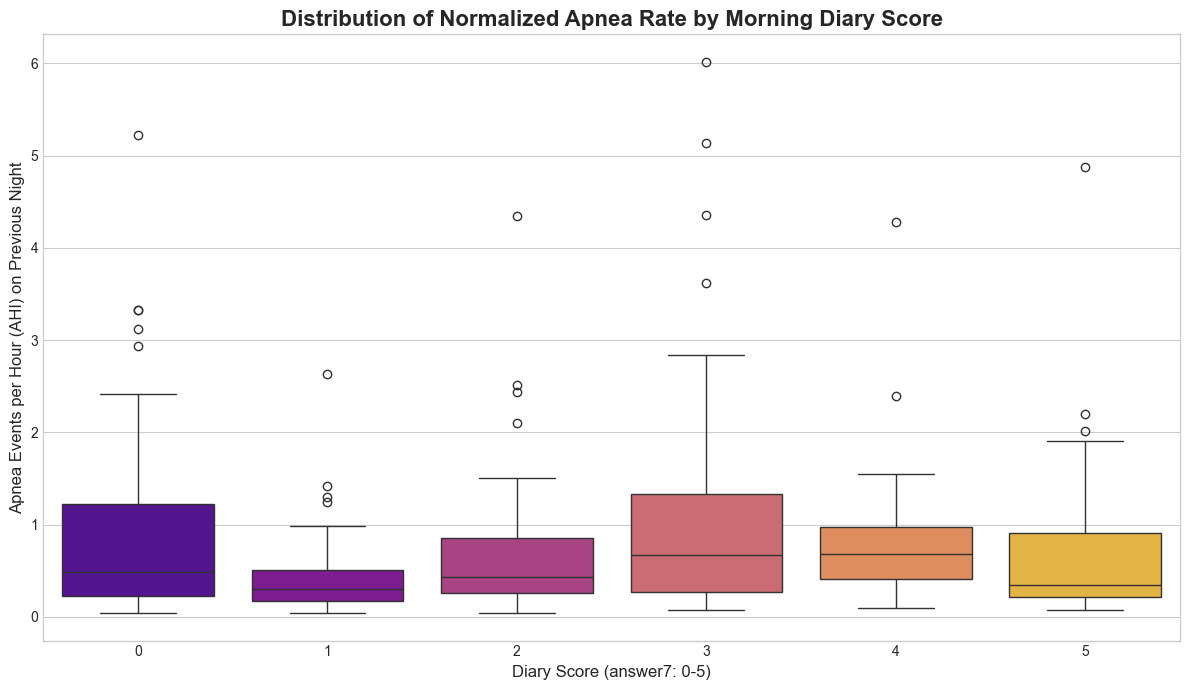

Saved normalized scatter plot to 'scatterplot_diary_vs_normalized_events.png'


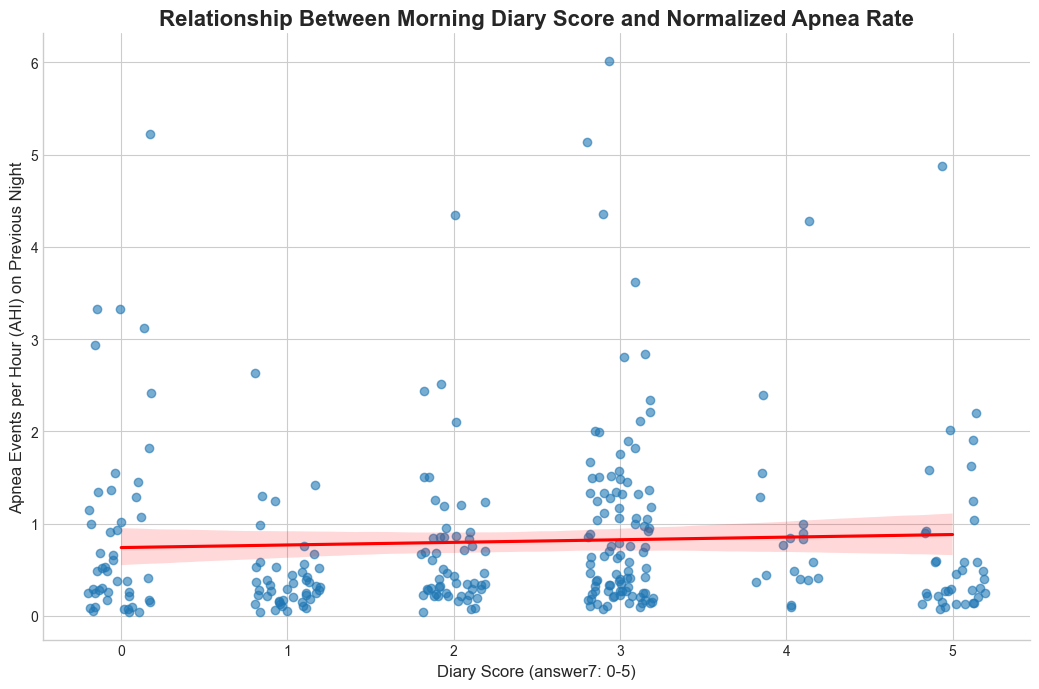

In [7]:
# plot_normalized_diary_correlation_fixed_concat.py

import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytz

def analyze_normalized_diary_vs_events(results_folder, data_root_folder):
    """
    Calculates the normalized event rate (AHI) for each night, aligns it with the
    next-morning diary score, and creates visualizations of their relationship.
    """
    SAMPLING_RATE_HZ = 12.5
    
    result_files = glob.glob(os.path.join(results_folder, "*_osa.csv"))
    if not result_files:
        print(f"Error: No result files found in '{results_folder}'.")
        return

    all_daily_data = []
    scotland_tz = pytz.timezone('Europe/London')

    for event_file_path in result_files:
        patient_id_prefix = os.path.basename(event_file_path).split('_osa.csv')[0]
        print(f"\nProcessing patient: {patient_id_prefix}")

        try:
            event_df = pd.read_csv(event_file_path)
            event_df['datetime'] = pd.to_datetime(event_df['date'] + ' ' + event_df['time'])
            event_df['SleepDate'] = event_df['datetime'].apply(
                lambda dt: (dt + pd.Timedelta(days=1)).strftime('%Y-%m-%d') if dt.hour >= 21 else dt.strftime('%Y-%m-%d')
            )
            apnea_counts_per_night = event_df.groupby('SleepDate').size().reset_index(name='EventCount')
        except Exception as e:
            print(f"  - Could not process apnea file {event_file_path}: {e}")
            continue

        raw_search_pattern = os.path.join(data_root_folder, f"{patient_id_prefix}*/Respeck/*.csv")
        raw_files = glob.glob(raw_search_pattern)
        if not raw_files: continue
        
        try:
            raw_df_list = [pd.read_csv(file, on_bad_lines='skip') for file in raw_files]
            raw_df_list = [df for df in raw_df_list if not df.empty]
            if not raw_df_list: continue
            raw_df = pd.concat(raw_df_list, ignore_index=True)
        except Exception as e:
            print(f"  - A critical error occurred while reading raw files for {patient_id_prefix}: {e}")
            continue
        
        def get_sleep_date(dt):
            if pd.isna(dt):
                return None
            if dt.hour >= 21:
                return (dt + pd.Timedelta(days=1)).strftime('%Y-%m-%d')
            else:
                return dt.strftime('%Y-%m-%d')

        raw_df['datetime'] = pd.to_datetime(raw_df['interpolatedPhoneTimestamp'], unit='ms', utc=True, errors='coerce').dt.tz_convert(scotland_tz)
        raw_df['SleepDate'] = raw_df['datetime'].apply(get_sleep_date)
        raw_df.dropna(subset=['SleepDate'], inplace=True)
        total_samples_per_night = raw_df.groupby('SleepDate').size().reset_index(name='SampleCount')

        nightly_summary = pd.merge(apnea_counts_per_night, total_samples_per_night, on='SleepDate', how='left')
        nightly_summary['RecordingTimeHours'] = nightly_summary['SampleCount'] / SAMPLING_RATE_HZ / 3600
        nightly_summary['EventsPerHour'] = nightly_summary.apply(
            lambda row: row['EventCount'] / row['RecordingTimeHours'] if row['RecordingTimeHours'] > 0 else 0,
            axis=1
        )
        
        diary_search = glob.glob(os.path.join(data_root_folder, f"{patient_id_prefix}*/Diary/*.csv"))
        if not diary_search: continue
        diary_file_path = diary_search[0]
        
        diary_df = pd.read_csv(diary_file_path)
        diary_df['datetime'] = pd.to_datetime(diary_df['timestamp'], unit='s', utc=True).dt.tz_convert(scotland_tz)
        diary_df['SleepDate'] = diary_df['datetime'].dt.strftime('%Y-%m-%d')
        diary_scores_per_day = diary_df[['SleepDate', 'answer7']].rename(columns={'answer7': 'DiaryScore'})
        diary_scores_per_day = diary_scores_per_day.drop_duplicates(subset='SleepDate', keep='last')

        final_summary = pd.merge(nightly_summary, diary_scores_per_day, on='SleepDate', how='inner')
        final_summary['PatientID'] = patient_id_prefix
        all_daily_data.append(final_summary)

    if not all_daily_data:
        print("No matching data found. Aborting.")
        return

    # <<< FIX: Use pd.concat to combine a list of DataFrames
    final_df = pd.concat(all_daily_data, ignore_index=True)
    
    final_df['DiaryScore'] = final_df['DiaryScore'].astype(int)

    print("\n" + "="*50)
    print("      FINAL MERGED & NORMALIZED DATA VERIFICATION")
    print("="*50)
    print(final_df[['PatientID', 'SleepDate', 'EventCount', 'RecordingTimeHours', 'EventsPerHour', 'DiaryScore']].head())
    print("="*50 + "\n")

    # --- PLOTTING ---
    print("--- Generating Plots ---")
    
    # ... (Plotting code remains the same) ...
    # PLOT 1: Box Plot
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))
    sns.boxplot(x='DiaryScore', y='EventsPerHour', data=final_df, palette='plasma')
    plt.title('Distribution of Normalized Apnea Rate by Morning Diary Score', fontsize=16, fontweight='bold')
    plt.xlabel('Diary Score (answer7: 0-5)', fontsize=12)
    plt.ylabel('Apnea Events per Hour (AHI) on Previous Night', fontsize=12)
    plt.tight_layout()
    plt.savefig("boxplot_diary_vs_normalized_events.png", dpi=300)
    print("\nSaved normalized box plot to 'boxplot_diary_vs_normalized_events.png'")
    plt.show()

    # PLOT 2: Scatter Plot
    sns.lmplot(
        x='DiaryScore',
        y='EventsPerHour',
        data=final_df,
        x_jitter=.2,
        height=7,
        aspect=1.5,
        scatter_kws={'alpha':0.6},
        line_kws={'color': 'red'}
    )
    plt.title('Relationship Between Morning Diary Score and Normalized Apnea Rate', fontsize=16, fontweight='bold')
    plt.xlabel('Diary Score (answer7: 0-5)', fontsize=12)
    plt.ylabel('Apnea Events per Hour (AHI) on Previous Night', fontsize=12)
    plt.tight_layout()
    plt.savefig("scatterplot_diary_vs_normalized_events.png", dpi=300)
    print("Saved normalized scatter plot to 'scatterplot_diary_vs_normalized_events.png'")
    plt.show()


if __name__ == "__main__":
    RESULTS_FOLDER = "./smile_osa_results"
    DATA_ROOT_FOLDER = "../data/Smile"
    analyze_normalized_diary_vs_events(RESULTS_FOLDER, DATA_ROOT_FOLDER)


Processing patient: PRB005

Processing patient: PRB202

Processing patient: PRB107

Processing patient: PRB203

Processing patient: PRB004

Processing patient: PRX018

Processing patient: PRB201

Processing patient: PRB105

Processing patient: PRB006

Processing patient: PRB007

Processing patient: PRB104

Processing patient: PRB108

Processing patient: PRB109

Processing patient: PRB003

Processing patient: PRB001
  - No diary file found for PRB001. Skipping.

Processing patient: PRB102

Processing patient: PRX900

Processing patient: PRB103

      FINAL MERGED DATA VERIFICATION
  PatientID   SleepDate  EventCount  DiaryScore
0    PRB005  2022-04-04           0           3
1    PRB005  2022-04-21           0           2
2    PRB202  2022-05-18           0           5
3    PRB202  2022-05-19          18           0
4    PRB202  2022-05-20           0           3

--- Generating Plots ---


/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_75829/2934076968.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily_summary['EventCount'].fillna(0, inplace=True)
/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_75829/2934076968.py:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values


Saved box plot to 'boxplot_diary_vs_total_events.png'


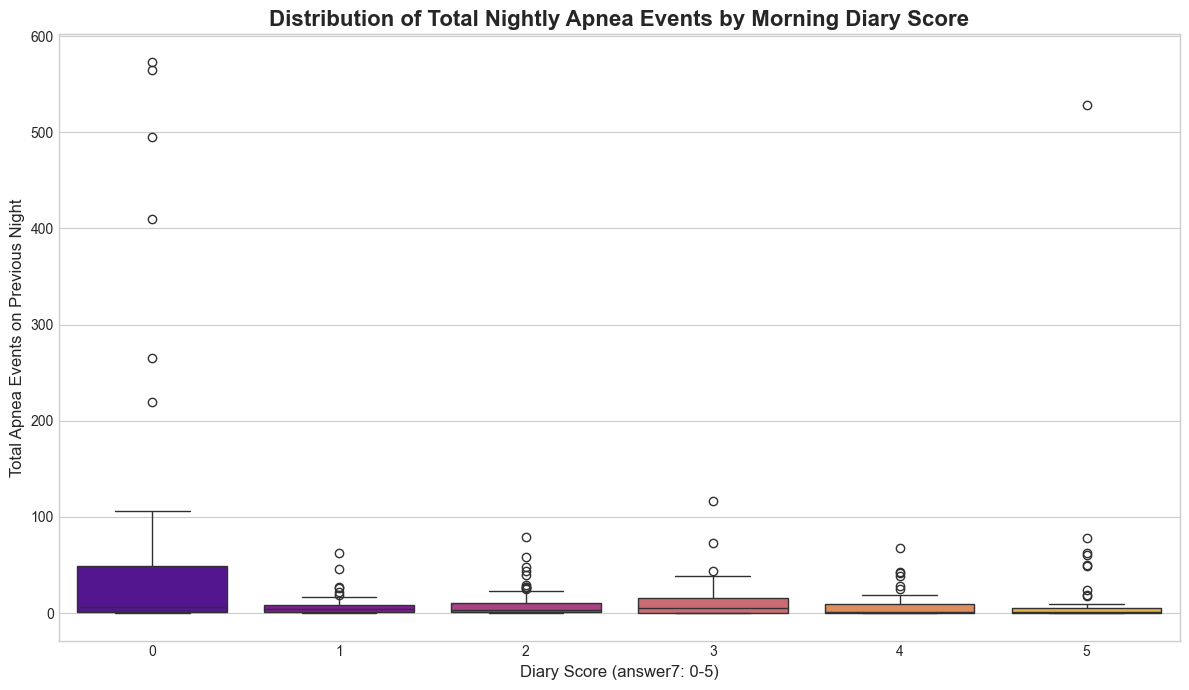

Saved colored scatter plot to 'scatterplot_diary_vs_total_events_colored.png'


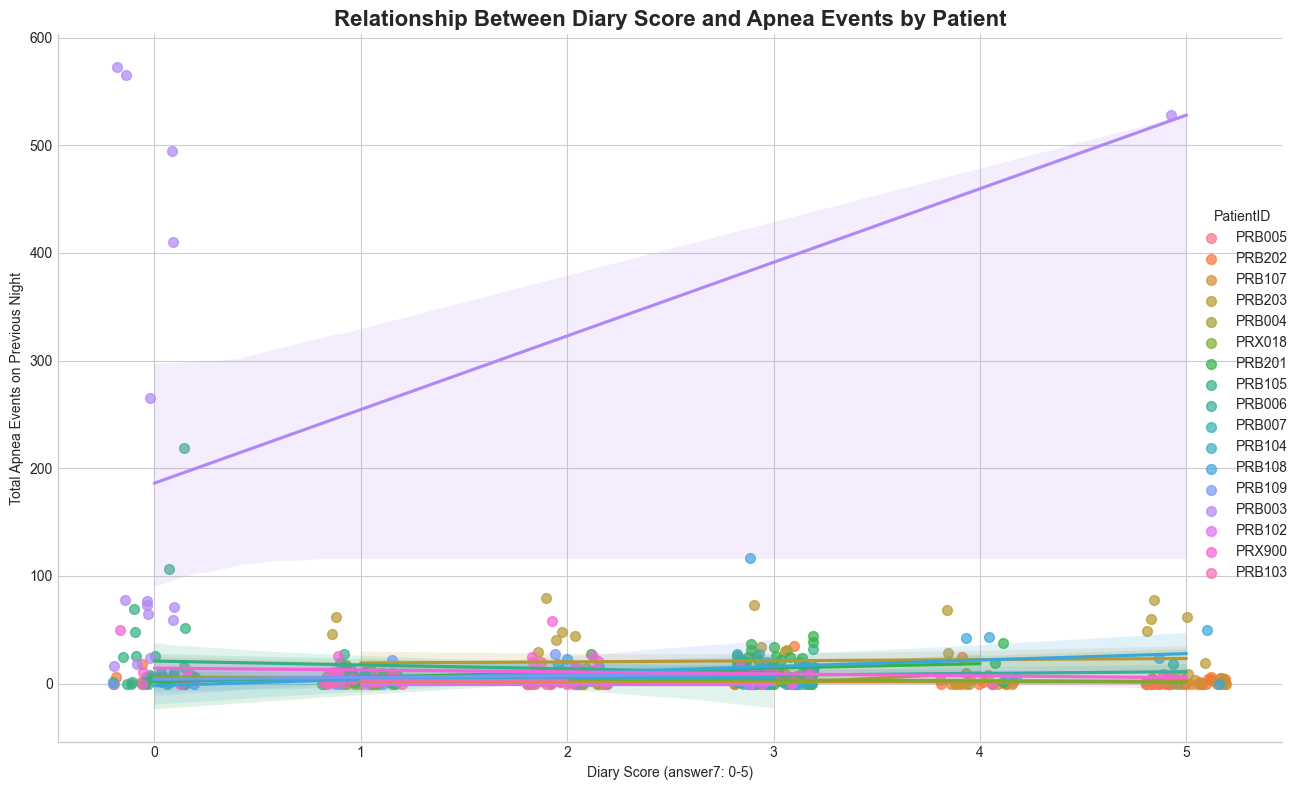

In [11]:
# plot_total_events_vs_diary_colored.py

import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytz

def analyze_total_events_vs_diary(results_folder, data_root_folder):
    """
    Loads diary scores and apnea event counts, correctly aligning them,
    and creates visualizations of their relationship.
    """
    result_files = glob.glob(os.path.join(results_folder, "*_osa.csv"))
    if not result_files:
        print(f"Error: No result files found in '{results_folder}'.")
        return

    all_daily_data = []
    scotland_tz = pytz.timezone('Europe/London')
    
    for event_file_path in result_files:
        patient_id_prefix = os.path.basename(event_file_path).split('_osa.csv')[0]
        print(f"\nProcessing patient: {patient_id_prefix}")

        try:
            event_df = pd.read_csv(event_file_path)
            if event_df.empty:
                apnea_counts_per_night = pd.DataFrame(columns=['SleepDate', 'EventCount'])
            else:
                event_df['datetime'] = pd.to_datetime(event_df['date'] + ' ' + event_df['time'])
                event_df['SleepDate'] = event_df['datetime'].apply(
                    lambda dt: (dt + pd.Timedelta(days=1)).strftime('%Y-%m-%d') if dt.hour >= 21 else dt.strftime('%Y-%m-%d')
                )
                apnea_counts_per_night = event_df.groupby('SleepDate').size().reset_index(name='EventCount')
        except Exception as e:
            print(f"  - Could not process apnea file {event_file_path}: {e}")
            continue

        diary_search = glob.glob(os.path.join(data_root_folder, f"{patient_id_prefix}*/Diary/*.csv"))
        if not diary_search:
            print(f"  - No diary file found for {patient_id_prefix}. Skipping.")
            continue
        diary_file_path = diary_search[0]

        try:
            diary_df = pd.read_csv(diary_file_path)
            diary_df['datetime'] = pd.to_datetime(diary_df['timestamp'], unit='s', utc=True).dt.tz_convert(scotland_tz)
            diary_df['SleepDate'] = diary_df['datetime'].dt.strftime('%Y-%m-%d')
            diary_scores_per_day = diary_df[['SleepDate', 'answer7']].rename(columns={'answer7': 'DiaryScore'})
            diary_scores_per_day = diary_scores_per_day.drop_duplicates(subset='SleepDate', keep='last')
        except Exception as e:
            print(f"  - Could not process diary file {diary_file_path}: {e}")
            continue

        daily_summary = pd.merge(apnea_counts_per_night, diary_scores_per_day, on='SleepDate', how='outer')
        daily_summary.dropna(subset=['DiaryScore'], inplace=True)
        daily_summary['EventCount'].fillna(0, inplace=True)
        daily_summary['PatientID'] = patient_id_prefix
        all_daily_data.append(daily_summary)

    if not all_daily_data:
        print("No matching data found. Aborting.")
        return

    final_df = pd.concat(all_daily_data, ignore_index=True)
    final_df['EventCount'] = final_df['EventCount'].astype(int)
    final_df['DiaryScore'] = final_df['DiaryScore'].astype(int)

    print("\n" + "="*50)
    print("      FINAL MERGED DATA VERIFICATION")
    print("="*50)
    print(final_df[['PatientID', 'SleepDate', 'EventCount', 'DiaryScore']].head())
    print("="*50 + "\n")

    # --- PLOTTING ---
    print("--- Generating Plots ---")
    
    # PLOT 1: Box Plot (This remains the same, showing the overall distribution)
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))
    sns.boxplot(x='DiaryScore', y='EventCount', data=final_df, palette='plasma')
    plt.title('Distribution of Total Nightly Apnea Events by Morning Diary Score', fontsize=16, fontweight='bold')
    plt.xlabel('Diary Score (answer7: 0-5)', fontsize=12)
    plt.ylabel('Total Apnea Events on Previous Night', fontsize=12)
    plt.tight_layout()
    plt.savefig("boxplot_diary_vs_total_events.png", dpi=300)
    print("\nSaved box plot to 'boxplot_diary_vs_total_events.png'")
    plt.show()

    # PLOT 2: Scatter Plot with colors for each patient
    # <<< MODIFIED: Added 'hue' and removed the single trend line
    g = sns.lmplot(
        x='DiaryScore',
        y='EventCount',
        data=final_df,
        hue='PatientID',      # Color points by PatientID
        fit_reg=True,        # Turn off the single regression line for all data
        x_jitter=.2,
        height=8,             # Increased height for better legend space
        aspect=1.5,
        scatter_kws={'alpha': 0.7, 's': 50}, # Adjust size and transparency
        legend=True           # Ensure legend is created
    )
    
    # Set the title for the plot
    g.ax.set_title('Relationship Between Diary Score and Apnea Events by Patient', fontsize=16, fontweight='bold')
    
    # Set axis labels (lmplot uses a different way to set labels)
    g.set_axis_labels('Diary Score (answer7: 0-5)', 'Total Apnea Events on Previous Night')
    
    plt.tight_layout()
    plt.savefig("scatterplot_diary_vs_total_events_colored.png", dpi=300)
    print("Saved colored scatter plot to 'scatterplot_diary_vs_total_events_colored.png'")
    plt.show()

if __name__ == "__main__":
    RESULTS_FOLDER = "./SMILE_ANALYSIS/smile_osa_cnn"
    DATA_ROOT_FOLDER = "../data/Smile"
    analyze_total_events_vs_diary(RESULTS_FOLDER, DATA_ROOT_FOLDER)

Found 18 patient result files. Processing and normalizing...

Processing patient: PRB005
  - Found 170 events across 31 unique nights.
  - Normalizing against 10040463 data points from the relevant nights.

Processing patient: PRB202
  - Found 183 events across 35 unique nights.
  - Normalizing against 9809686 data points from the relevant nights.

Processing patient: PRB107
  - Found 152 events across 43 unique nights.
  - Normalizing against 9149276 data points from the relevant nights.

Processing patient: PRB203
  - Found 1540 events across 66 unique nights.
  - Normalizing against 34710725 data points from the relevant nights.

Processing patient: PRB004
  - Found 27 events across 3 unique nights.
  - Normalizing against 1148989 data points from the relevant nights.

Processing patient: PRX018
  - Found 332 events across 53 unique nights.
  - Normalizing against 26420669 data points from the relevant nights.

Processing patient: PRB201
  - Found 781 events across 46 unique nights.

/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_75829/3454405683.py:114: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='PatientID', y='NormalizedRate', data=normalized_df_sorted, palette='viridis_r')



Plot successfully saved to 'patient_events_per_datapoint_corrected.png'


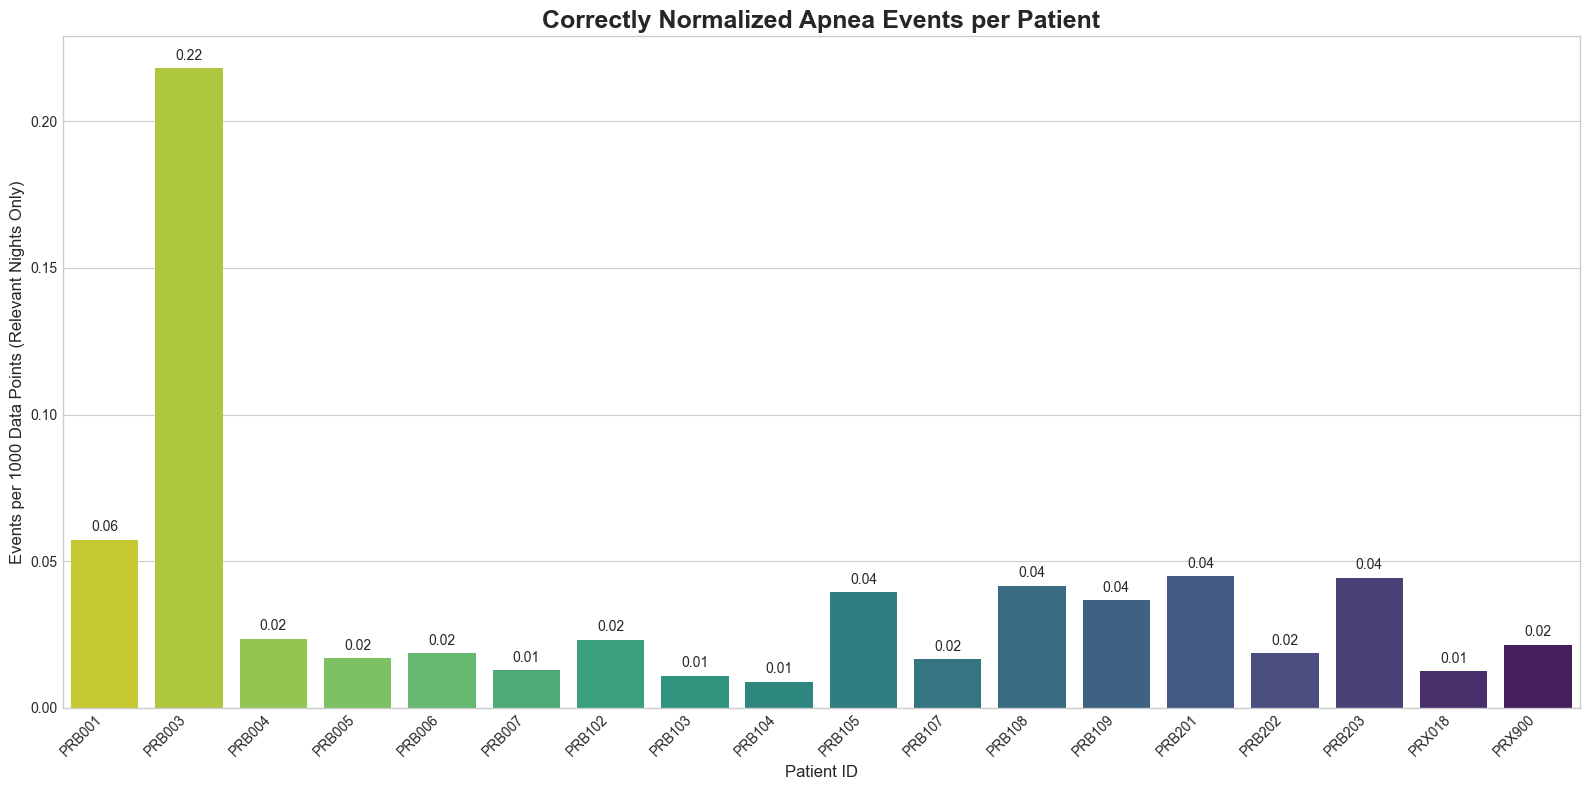

In [13]:
# plot_events_per_datapoint_corrected.py

import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytz

def plot_normalized_events_per_patient(results_folder, data_root_folder, output_filename="patient_events_per_datapoint_corrected.png"):
    """
    Calculates the average apnea events per data point for each patient by
    normalizing event counts with the number of raw data samples from ONLY
    the nights included in the analysis.
    """
    search_pattern = os.path.join(results_folder, "*_osa.csv")
    result_files = glob.glob(search_pattern)

    if not result_files:
        print(f"Error: No '*_osa.csv' files found in the folder: '{results_folder}'")
        return

    print(f"Found {len(result_files)} patient result files. Processing and normalizing...")

    patient_normalized_data = {}
    scotland_tz = pytz.timezone('Europe/London')

    for file_path in result_files:
        filename = os.path.basename(file_path)
        patient_id_prefix = filename.split('_osa.csv')[0]
        print(f"\nProcessing patient: {patient_id_prefix}")

        # --- 1. Get total event count AND the list of analyzed dates ---
        try:
            event_df = pd.read_csv(file_path)
            total_event_count = len(event_df)
            
            # Get a unique set of dates that were actually included in the results
            if not event_df.empty:
                analyzed_dates = set(event_df['date'].unique())
                print(f"  - Found {total_event_count} events across {len(analyzed_dates)} unique nights.")
            else:
                analyzed_dates = set()
                print("  - No events found for this patient.")

        except Exception as e:
            print(f"  - Could not process event file {file_path}: {e}")
            continue

        # If there are no events, the normalized rate is 0
        if total_event_count == 0:
            patient_normalized_data[patient_id_prefix] = 0
            continue

        # --- 2. Load all raw data ---
        raw_search_pattern = os.path.join(data_root_folder, f"{patient_id_prefix}*/Respeck/*.csv")
        raw_files = glob.glob(raw_search_pattern)
        if not raw_files:
            print(f"  - WARNING: No raw data files found for {patient_id_prefix}. Cannot normalize.")
            continue

        try:
            raw_df_list = [pd.read_csv(file, on_bad_lines='skip') for file in raw_files]
            raw_df_list = [df for df in raw_df_list if not df.empty]
            if not raw_df_list:
                print(f"  - WARNING: All raw files were empty for {patient_id_prefix}.")
                continue
            
            raw_df = pd.concat(raw_df_list, ignore_index=True)
            
            # --- 3. Filter raw data to match ONLY the analyzed dates ---
            raw_df['datetime'] = pd.to_datetime(raw_df['interpolatedPhoneTimestamp'], unit='ms', errors='coerce', utc=True).dt.tz_convert(scotland_tz)
            raw_df['date_str'] = raw_df['datetime'].dt.strftime('%Y-%m-%d')
            
            # Keep only the rows from the raw data that match the dates in our event file
            relevant_raw_df = raw_df[raw_df['date_str'].isin(analyzed_dates)]
            
            if relevant_raw_df.empty:
                print(f"  - WARNING: No raw data matched the analyzed dates. Cannot normalize.")
                patient_normalized_data[patient_id_prefix] = 0
                continue
            
            # --- 4. Now, count samples within the sleep window from this relevant data ---
            hour = relevant_raw_df['datetime'].dt.hour
            sleep_window_mask = ~hour.between(10, 20)
            sleep_samples_df = relevant_raw_df[sleep_window_mask]
            
            total_samples_for_normalization = len(sleep_samples_df)
            
            print(f"  - Normalizing against {total_samples_for_normalization} data points from the relevant nights.")

            # --- 5. Calculate Events per Data Point ---
            if total_samples_for_normalization > 0:
                normalized_rate = (total_event_count / total_samples_for_normalization) * 1000
            else:
                normalized_rate = 0
            
            patient_normalized_data[patient_id_prefix] = normalized_rate

        except Exception as e:
            print(f"  - An error occurred processing raw data for {patient_id_prefix}: {e}")

    # --- Prepare data for plotting ---
    if not patient_normalized_data:
        print("No valid patient data to plot.")
        return

    normalized_df = pd.DataFrame(list(patient_normalized_data.items()), columns=['PatientID', 'NormalizedRate'])
    normalized_df_sorted = normalized_df.sort_values('PatientID', ascending=True)

    # --- Create and customize the plot ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(16, 8))
    ax = sns.barplot(x='PatientID', y='NormalizedRate', data=normalized_df_sorted, palette='viridis_r')

    for p in ax.patches:
        ax.annotate(
            format(p.get_height(), '.2f'),
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', xytext=(0, 9), textcoords='offset points'
        )

    plt.title('Correctly Normalized Apnea Events per Patient', fontsize=18, fontweight='bold')
    plt.xlabel('Patient ID', fontsize=12)
    plt.ylabel('Events per 1000 Data Points (Relevant Nights Only)', fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    # --- Save and show the plot ---
    plt.savefig(output_filename, dpi=300)
    print(f"\nPlot successfully saved to '{output_filename}'")
    
    plt.show()

if __name__ == "__main__":
    RESULTS_FOLDER = "./SMILE_ANALYSIS/smile_osa_cnn"
    DATA_ROOT_FOLDER = "../data/Smile"
    
    plot_normalized_events_per_patient(
        results_folder=RESULTS_FOLDER,
        data_root_folder=DATA_ROOT_FOLDER
    )


Processing patient: PRB005

Processing patient: PRB202

Processing patient: PRB107

Processing patient: PRB203

Processing patient: PRB004

Processing patient: PRX018

Processing patient: PRB201

Processing patient: PRB105

Processing patient: PRB006

Processing patient: PRB007

Processing patient: PRB104

Processing patient: PRB108

Processing patient: PRB109

Processing patient: PRB003

Processing patient: PRB001

Processing patient: PRB102

Processing patient: PRX900

Processing patient: PRB103

      FINAL MERGED & NORMALIZED DATA VERIFICATION
  PatientID   SleepDate  EventCount  SampleCount  EventsPer1000Points  \
0    PRB202  2022-05-19          18       768332             0.023427   
1    PRB202  2022-05-22           1       493117             0.002028   
2    PRB202  2022-05-23           2       793713             0.002520   
3    PRB202  2022-05-24           3       783951             0.003827   
4    PRB202  2022-05-26           1      1026565             0.000974   

   Dia

/var/folders/qj/1f20_52j2yj49hjhy3ht9wzw0000gn/T/ipykernel_75829/2540700438.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='DiaryScore', y='EventsPer1000Points', data=final_df, palette='plasma')


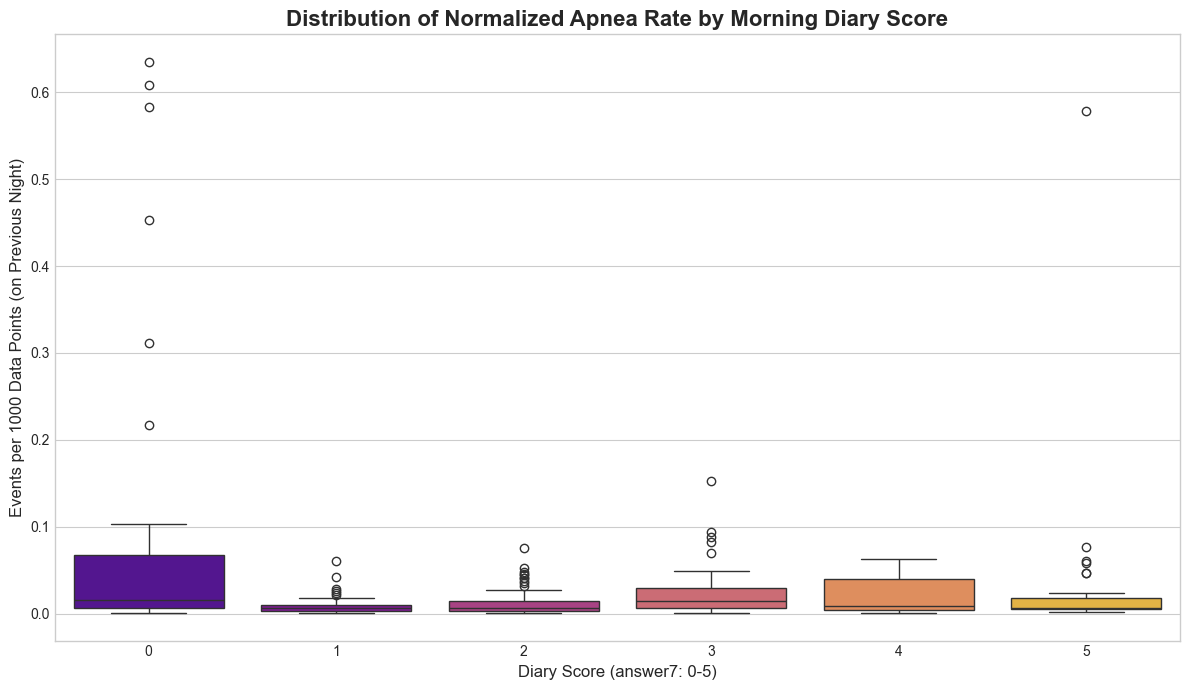

Saved normalized scatter plot to 'scatterplot_diary_vs_datapoint_events.png'


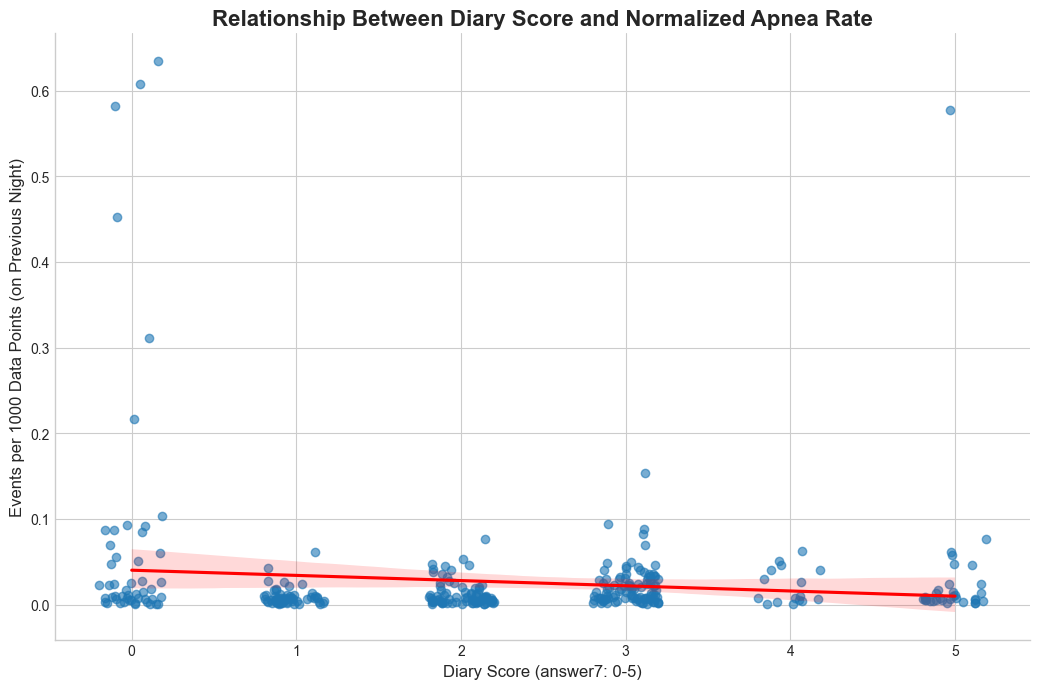

In [14]:
# plot_diary_vs_datapoint_normalized_events.py

import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pytz

def analyze_diary_vs_datapoint_events(results_folder, data_root_folder):
    """
    Calculates the event rate per 1000 data points for each night, aligns it with the
    next-morning diary score, and creates visualizations of their relationship.
    """
    result_files = glob.glob(os.path.join(results_folder, "*_osa.csv"))
    if not result_files:
        print(f"Error: No result files found in '{results_folder}'.")
        return

    all_nightly_data = []
    scotland_tz = pytz.timezone('Europe/London')

    for event_file_path in result_files:
        patient_id_prefix = os.path.basename(event_file_path).split('_osa.csv')[0]
        print(f"\nProcessing patient: {patient_id_prefix}")

        # --- A. Load Apnea Events and group by SleepDate ---
        try:
            event_df = pd.read_csv(event_file_path)
            event_df['datetime'] = pd.to_datetime(event_df['date'] + ' ' + event_df['time'])
            event_df['SleepDate'] = event_df['datetime'].apply(
                lambda dt: (dt + pd.Timedelta(days=1)).strftime('%Y-%m-%d') if dt.hour >= 21 else dt.strftime('%Y-%m-%d')
            )
            apnea_counts_per_night = event_df.groupby('SleepDate').size().reset_index(name='EventCount')
        except Exception as e:
            print(f"  - Could not process apnea file {event_file_path}: {e}")
            continue

        # --- B. Load Raw Data and get total sample count per SleepDate ---
        raw_search_pattern = os.path.join(data_root_folder, f"{patient_id_prefix}*/Respeck/*.csv")
        raw_files = glob.glob(raw_search_pattern)
        if not raw_files: continue
        
        try:
            raw_df_list = [pd.read_csv(file, on_bad_lines='skip') for file in raw_files]
            raw_df_list = [df for df in raw_df_list if not df.empty]
            if not raw_df_list: continue
            raw_df = pd.concat(raw_df_list, ignore_index=True)
        except Exception as e:
            print(f"  - An error occurred while reading raw files for {patient_id_prefix}: {e}")
            continue
        
        # Create SleepDate for raw data
        raw_df['datetime'] = pd.to_datetime(raw_df['interpolatedPhoneTimestamp'], unit='ms', errors='coerce', utc=True).dt.tz_convert(scotland_tz)
        raw_df['SleepDate'] = raw_df['datetime'].apply(lambda dt: (dt + pd.Timedelta(days=1)).strftime('%Y-%m-%d') if pd.notna(dt) and dt.hour >= 21 else (dt.strftime('%Y-%m-%d') if pd.notna(dt) else None))
        raw_df.dropna(subset=['SleepDate'], inplace=True)
        
        # Count samples per night
        total_samples_per_night = raw_df.groupby('SleepDate').size().reset_index(name='SampleCount')

        # --- C. Merge event and sample counts ---
        nightly_summary = pd.merge(apnea_counts_per_night, total_samples_per_night, on='SleepDate', how='left')

        # --- D. Calculate the Normalized Rate (Events per 1000 Data Points) ---
        nightly_summary['EventsPer1000Points'] = nightly_summary.apply(
            lambda row: (row['EventCount'] / row['SampleCount']) * 1000 if row['SampleCount'] > 0 else 0,
            axis=1
        )
        
        # --- E. Load and Align Diary Data ---
        diary_search = glob.glob(os.path.join(data_root_folder, f"{patient_id_prefix}*/Diary/*.csv"))
        if not diary_search: continue
        
        diary_df = pd.read_csv(diary_search[0])
        diary_df['datetime'] = pd.to_datetime(diary_df['timestamp'], unit='s', utc=True).dt.tz_convert(scotland_tz)
        diary_df['SleepDate'] = diary_df['datetime'].dt.strftime('%Y-%m-%d')
        diary_scores_per_day = diary_df[['SleepDate', 'answer7']].rename(columns={'answer7': 'DiaryScore'}).drop_duplicates(subset='SleepDate', keep='last')

        # --- F. Final Merge: Normalized Rate data with Diary data ---
        final_summary = pd.merge(nightly_summary, diary_scores_per_day, on='SleepDate', how='inner')
        final_summary['PatientID'] = patient_id_prefix
        all_nightly_data.append(final_summary)

    # --- Create Final DataFrame & Print Verification ---
    if not all_nightly_data:
        print("No matching data found. Aborting.")
        return

    final_df = pd.concat(all_nightly_data)
    final_df['DiaryScore'] = final_df['DiaryScore'].astype(int)

    print("\n" + "="*50)
    print("      FINAL MERGED & NORMALIZED DATA VERIFICATION")
    print("="*50)
    print(final_df[['PatientID', 'SleepDate', 'EventCount', 'SampleCount', 'EventsPer1000Points', 'DiaryScore']].head())
    print("="*50 + "\n")

    # --- Plotting ---
    print("--- Generating Plots ---")
    
    # PLOT 1: Box Plot
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 7))
    sns.boxplot(x='DiaryScore', y='EventsPer1000Points', data=final_df, palette='plasma')
    plt.title('Distribution of Normalized Apnea Rate by Morning Diary Score', fontsize=16, fontweight='bold')
    plt.xlabel('Diary Score (answer7: 0-5)', fontsize=12)
    plt.ylabel('Events per 1000 Data Points (on Previous Night)', fontsize=12)
    plt.tight_layout()
    plt.savefig("boxplot_diary_vs_datapoint_events.png", dpi=300)
    print("\nSaved normalized box plot to 'boxplot_diary_vs_datapoint_events.png'")
    plt.show()

    # PLOT 2: Scatter Plot
    sns.lmplot(
        x='DiaryScore',
        y='EventsPer1000Points',
        data=final_df,
        x_jitter=.2,
        height=7,
        aspect=1.5,
        scatter_kws={'alpha':0.6},
        line_kws={'color': 'red'}
    )
    plt.title('Relationship Between Diary Score and Normalized Apnea Rate', fontsize=16, fontweight='bold')
    plt.xlabel('Diary Score (answer7: 0-5)', fontsize=12)
    plt.ylabel('Events per 1000 Data Points (on Previous Night)', fontsize=12)
    plt.tight_layout()
    plt.savefig("scatterplot_diary_vs_datapoint_events.png", dpi=300)
    print("Saved normalized scatter plot to 'scatterplot_diary_vs_datapoint_events.png'")
    plt.show()

if __name__ == "__main__":
    RESULTS_FOLDER = "./SMILE_ANALYSIS/smile_osa_cnn"
    DATA_ROOT_FOLDER = "../data/Smile"
    analyze_diary_vs_datapoint_events(RESULTS_FOLDER, DATA_ROOT_FOLDER)